In [7]:
import emcee
#import triangle
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from astropy.io import fits
from scipy.integrate import quad
%matplotlib inline

import random
from numpy import exp
import corner

In [2]:
# Import Data
filenm = 'clstreg_all_final.fits'
data, hdr = fits.getdata(filenm, 1, header=True)
mclst_all = data['mass_best']
aclst_all = data['age_best']
wage100 = aclst_all < 8.0
wage250 = aclst_all >= 8.0
mclst_age100 = mclst_all[wage100]
mclst_age250 = mclst_all[wage250]
#mclst_obs_err = (data['mass_p84']-data['mass_p16'])/2.

compdata = np.genfromtxt('compdat_envreg_all.dat', dtype=None, names=True)
mlim = compdata['Comp50_100'][9]
alim = compdata['SParam_100'][9]
mlim250 = compdata['Comp50_250'][9]
alim250 = compdata['SParam_250'][9]

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if sys.path[0] == '':


In [3]:
sel100 = mclst_age100 > np.log10(mlim)
sel250 = mclst_age250 > np.log10(mlim250)
clst_data = mclst_age100[sel100], mclst_age250[sel250]

fldprop = mlim, alim, mlim250, alim250

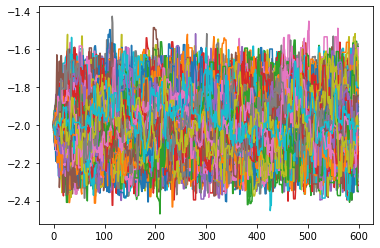

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


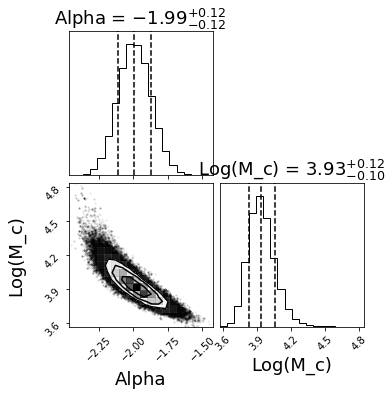

In [12]:
def schechter_pobs(x, alpha=-2.0, M_c=2.e4, x0=2.85, s=4.5, A=1.):
    pobs = 1./( 1. + np.exp((-s)*(np.log10(x)-x0)) )
    mimc=x/M_c
    return A * mimc**alpha * np.exp(-mimc) * pobs

def logistic_curve(x,x0=2.85,s=4.5):
    return 1./( 1. + np.exp((-s)*(x-x0)) )

def lnprior(theta):
    alpha, mfmax = theta
    if -3 <= alpha <= -1 and 3 <= mfmax <= 8:
        return 0.0
    return -np.inf

def lnlike(theta, clst_data, fldprop):
    alpha, logmfmax = theta
    mlim, alim, mlim250, alim250 = fldprop
    mclst_age100, mclst_age250 = clst_data

    linmax = 10.**logmfmax
    
    pobs = logistic_curve(mclst_age100,x0=np.log10(mlim),s=alim)
    linm = 10.**mclst_age100
    mimc = linm/linmax # m_i / M_c
    norm = quad(schechter_pobs, mlim, 1.e7, args=(alpha, linmax, np.log10(mlim), alim))
    lnlike_100 = np.sum( np.log(pobs) + (alpha*np.log(mimc)) - mimc - np.log(norm[0]))

    pobs2 = logistic_curve(mclst_age250,x0=np.log10(mlim250),s=alim250)
    linm2 = 10.**mclst_age250
    mimc2 = linm2/linmax # m_i / M_c
    norm2 = quad(schechter_pobs, mlim250, 1.e7, args=(alpha, linmax, np.log10(mlim250), alim250))
    lnlike_250 = np.sum( np.log(pobs2) + (alpha*np.log(mimc2)) - mimc2 - np.log(norm2[0]))

    return lnlike_100+lnlike_250

def lnprob(theta, clst_data, fldprop):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, clst_data, fldprop)

starting_point=np.array([-2., 4.])

ndim, nwalkers = 2, 500
nsteps= 600
burnin=100
pos = starting_point + 1e-2*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(clst_data, fldprop))
sampler.run_mcmc(pos, nsteps)

#plot chain
plt.plot(np.transpose(sampler.chain[:,:,0]))
plt.show()
sampler.chain
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["Alpha", "Log(M_c)"], label_kwargs={"fontsize": 18},
                                     quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})

fig.show()